# Predicción series temporales. MLP

En este notebook se llevará a cabo la implementación de un perceptrón multicapa, con el objetivo de realizar la predicción de la evolución de una serie temporal. En particular, se utilizará la señal de saturación de la poligrafía nocturna.

In [1]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

import pickle
import time
import os
import matplotlib.pyplot as plt
from paciente import Paciente
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # En caso de que no queramos que acceda a GPU

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#CF9962", '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']) 

In [2]:
def to_supervised(data, n_input: int, n_out: int, n_margin: int=1, drop_extremes_percentaje:float=0.0):
	"""Convertir los datos a un problema supervisado

	Se transforma el conjunto de datos a un dataset con entradas - salidas.

	Args:
		data (list):  
			Lista con todos los datos de la serie que se quiere transformar.

		n_input (int): 
			Numero de atributos (entradas) de cada muestra a generar.  

		n_out (int): 
			Numero de salidas de cada muestra a generar. 

		n_margin (int): 
			Margen entre una muestra y la siguiente que se genera.
		
		drop_extremes_percentaje (float):
			Porcentaje del conjunto de datos que se quiere eliminar de los extremos
			del conjunto de datos. 0.1 indica que se quiere eliminar un 10% del
			inicio de la muestra, y un 10% del final de la muestra.


	Returns:
		list: 
			El primer elemento corresponde con las entradas (X) del conjunto
			de datos y el segundo con las salidas (y).
	"""

	if drop_extremes_percentaje > 0 and drop_extremes_percentaje < 0.5: # Elimino los extremos de la muestra.
		data = data[int(len(data)*drop_extremes_percentaje):-int(len(data)*drop_extremes_percentaje)]

	X, y = list(), list()
	in_start = 0

	for _ in range(len(data)):
		# Definimos comienzo y fin de la muestra de entrada y de salida
		in_end = in_start + n_input
		out_end = in_end + n_out
		
		# Comprobamos que tenemos datos suficientes
		if out_end <= len(data):
			x_input = data[in_start:in_end]
			X.append(x_input)
			y.append(data[in_end:out_end])

		# Nos movemos tantos pasos como nos digan en n_margin
		in_start += n_margin
	return np.array(X), np.array(y)

In [3]:
def train_test_split(data, train_size:float=0.8):
    """División en conjuntos de entrenamiento y test

    Args:
        data (list):  
            Lista con los valores que se desean dividir en conjuntos de entrenamiento
            y test.

        train_size (float): 
            Porcentaje de datos destinados al conjunto de entrenamiento.  

    Returns:
        list: 
            El primer elemento corresponde con los datos para entrenamiento,
            y el segundo con los datos para test.
    """
    number_samples_train = int(train_size*len(data))
    return data[:number_samples_train], data[number_samples_train:]

In [4]:
def make_distance_predictions(total_seconds_prediction, number_samples, test_x, n_margin, n_input, n_out, target_real, model, time_step):
	"""Función para generar predicciones de forma recursiva

	Args:
		total_seconds_prediction (int):
			Numero de segundos que se quieren predecir en la nueva muestra.

		number_samples (int):
			Numero de muestras del conjunto de entrenamiento sobre las que se
			desea aplicar la predicción recursiva

		test_x (np.matrix):
			Conjunto de entrenamiento

		n_margin (int):
			Margen entre muestra y muestra establecido al generar los datos

		n_input (int):
			Número de entradas de cada muestra establecido al generar los datos

		n_out (int):
			Número de salidas de cada muestra establecido al generar los datos

		target_real (np.array):
			Evolucion real completa de la serie temporal

		model (keras.Sequential):
			Modelo de red neuronal entrenado

		time_step (int):
			Time step del paciente


	Returns:
		list: 
			El primer elemento corresponde con una lista de listas, que contiene todas,
			las predicciones que ha realizado el modelo, y el segundo elemento contiene
			una lista de listas, con la salida real.
	"""
	forward_predicted_list = []
	forward_real_list = []
	number_forward_predictions = calcular_numero_forward_predictions(total_seconds_prediction=total_seconds_prediction, time_step=time_step, n_out=n_out) # Indica cuantas veces tenemos que predecir la salida

	# Calculamos las predicciones a total_seconds_prediction segundos para las number_samples de test primeras muestras
	for i, sample in enumerate(tqdm(test_x[:number_samples])): 
		predicted = sample_forward_prediction(initial_sample=sample, number_forward_predictions=number_forward_predictions, model=model)
		forward_predicted_list.append(predicted)

		# Almacenamos los resultados reales
		inicio_tramo_real = (i*n_margin)+n_input
		fin_tramo_real = (i*n_margin)+(number_forward_predictions*n_out)+n_input
		real = np.array([target_real[idx] for idx in range(inicio_tramo_real, fin_tramo_real)])
		forward_real_list.append(real)

	forward_predicted_list = np.array(forward_predicted_list)
	forward_real_list = np.array(forward_real_list)

	return forward_predicted_list, forward_real_list

In [5]:
def calcular_numero_forward_predictions(total_seconds_prediction, time_step, n_out):
	"""Calcula numero de predicciones que hay que realizar recursivamente

	Calcula cuantas predicciones hay que realizar de forma sucesiva para llegar al 
	objetivo de segundos de prediccion.

	Args:
		total_seconds_prediction (int):
			Numero de segundos que se quieren predecir en la nueva muestra.

		n_out (int):
			Número de salidas de cada muestra establecido al generar los datos

		time_step (int):
			Time step del paciente

	Returns:
		int: 
			Número de veces que hay que realizar las predicciones para
			alcanzar el objetivo de segundos. 
	"""
	required_outputs = total_seconds_prediction/time_step
	return round(required_outputs/n_out)

In [6]:
def plot_y_sample_i(data, n_margin, n_input, data_index, label = "test_sample", marker='x', color = None):
    """Traza gráficamente la representación de una muestra

    A partir de un conjunto de datos, indicando el índice de la muestra que se 
    desea trazar, la representa en el gráfico teniendo en cuneta el margen entre
    cada muestra del conjunto de datos.

    Args:
        data (int):
            Numero de segundos que se quieren predecir en la nueva muestra.

        n_margin (int):
            Margen entre muestra y muestra establecido al generar los datos.

        n_input (int):
            Número de entradas de cada muestra establecido al generar los datos.

        data_index (int):
            Índice que indica la posición de la muestra.

        label (str):
            Indica la etiqueta que se quiere utilizar para representar la traza

        marker (str):
            Indica el marcador que se quiere utilizar para representar la traza

        color (str):
            Indica el color que se quiere utilizar para representar la traza

    Returns:
        int: 
            Número de veces que hay que realizar las predicciones para
            alcanzar el objetivo de segundos. 
    """
    ini = n_input + (data_index*n_margin)
    r = range(ini, ini+len(data[data_index]))
    if color is None: return plt.plot(r, data[data_index], marker=marker,  label=label)
    else: return plt.plot(r, data[data_index], marker=marker, color=color, label=label)

In [7]:
def plot_predictions(prediction_indices, predictions, test_y, target_real, n_margin, n_input, n_out, time_step, title, savefig=False):
    """Traza gráficamente la representación de una muestra

    A partir de un conjunto de datos, indicando el índice de la muestra que se 
    desea trazar, la representa en el gráfico teniendo en cuneta el margen entre
    cada muestra del conjunto de datos.

    Args:
        prediction_indices (list):
            Indices de la lista de predicciones que se desean mostrar.

        predictions (int):
            Predicciones generadas por el modelo.

		test_y (list):  
			Conjunto de datos de test.

		target_real (np.array):
			Evolucion real completa de la serie temporal

		n_input (int): 
			Numero de atributos (entradas) de cada muestra a generar.  

		n_out (int): 
			Numero de salidas de cada muestra a generar. 

		n_margin (int): 
			Margen entre una muestra y la siguiente que se genera.

		time_step (int):
			Time step del paciente

        savefig (bool):
            Indica si se quiere almacenar el gráfico del resultado en un 
            fichero pdf. Defaults a False.
    """
    test_y = deepcopy(test_y)
    predictions = deepcopy(predictions)
    target_real = deepcopy(target_real)

    plt.figure(figsize=(15, 5))
    plt.title(f"Prediccion evolucion {title} a {round(n_out*time_step)} segundos")
    plt.ylabel("spo2")
    plt.xlabel("Segundos")

    label_test = "Tramo real"
    label_prediction = "Tramo estimado"
    for idx in prediction_indices:
        #plot_y_sample_i(data=test_y, n_margin=n_margin, n_input=n_input, data_index=idx, color="green", label=label_test)
        plot_y_sample_i(data=predictions, n_margin=n_margin, n_input=n_input, data_index=idx, marker='x', color="C1", label=label_prediction)

        label_test, label_prediction = "", ""

    target_real_plot = target_real[:(max(prediction_indices)*n_margin)+n_out+n_input]

    plt.plot(target_real_plot, label="Secuencia total real", color="C0")

    number_ticks = 10
    x_ticks_pos = list(range(len(target_real_plot)))
    x_ticks_pos = x_ticks_pos[::int(len(x_ticks_pos)/10)]
    x_ticks_label = [round(i*time_step) for i in x_ticks_pos]

    plt.xticks(x_ticks_pos, x_ticks_label)

    plt.legend()
    if savefig: plt.savefig(f'{title}_{time.time()}.png', transparent=True)
    plt.show()

In [8]:
def sample_forward_prediction(initial_sample, number_forward_predictions, model) -> list:
    """Realiza recursivamente la prediccion de una muestra

    Dada una muestra, un modelo, y el numero de predicciones recursivas que se desean,
    recursivamente se van realizando las mismas.

    Args:
        initial_sample (list):
            Muestra inicial a partir de la cual se quieren realizar predicciones recursivas.

        number_forward_predictions (int):
            Número de predicciones recursivas que se desean realizar.

        model (keras.Sequential):
            Modelo de red neuronal entrenado

    Returns:
        list: 
            Lista con las predicciones del modelo recursivas. 
    """
    predicciones = []

    current_sample = deepcopy(initial_sample)

    for _ in range(number_forward_predictions):
        # Modificamos estructura para que la red pueda realizar una prediccion
        current_sample_reshaped = np.reshape(current_sample, (1, -1)) 

        prediccion = model.predict(current_sample_reshaped)
        prediccion = np.reshape(prediccion, (prediccion.shape[1])) # Modificamos dimensiones para que sea una lista plana

        predicciones.extend(prediccion)

        # Modifico la muestra actual para que contenga los nuevos elementos que se han predecido
        current_sample = np.concatenate((current_sample[len(prediccion):], prediccion))

    return predicciones

In [1]:
def evaluate_forecasts(actual, predicted):
	"""Calcula el RMSE dada las predicciones y los valores reales

	A partir de las predicciones y los valores reales, se calcula tanto el RMSE
	global del modelo, como el RMSE a cada una de las distancias disponibles
	en la predicción.

	Args:
		actual (list):
			Lista con los valores reales de la salida de las muestras del
			conjunto de datos.

		predicted (list):
			Lista con los valores predecidos de la salida de las muestras del
			conjunto de datos.

	Returns:
		list: 
			El primer elemento representa el RMSE de todo el conjunto de datos, 
			y el segundo elemento de la lista es una lista que representa los
			valores del RMSE en función de la distancia a la predicción. 
	"""
	scores = list()

	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [10]:
def summarize_scores(score, scores):
	"""Realiza el resumen de los resultados del RMSE

	Dado el RMSE global, y el RMSE en función de la distancia a la predicción,
	se representa gráficamente el mismo.

	Args:
		score (int):
			RMSE de todo el conjunto de datos.

		scores (list):
			lista que representa los valores del RMSE en función de la 
			distancia a la predicción.
			
    See Also:
        evaluate_forecasts().
	"""
	s_scores = ', '.join(['%.2f' % s for s in scores])
	print('Root Mean Squared Error: [%.3f]. RMSE in predictions at n step %s' % (score, s_scores))

	# Estableces el numero de ticks en el eje horizontal, así como el nombre de los ticks
	if len(scores) > 1:
		labels = [f"{round((i+1)*time_step, 1)}" for i in range(len(scores))]
		num_ticks = 10
		ticks_step = int(len(labels)/num_ticks)
		x_ticks_pos = list(range(len(labels)))[::ticks_step]
		x_ticks_label = labels[::ticks_step]
		plt.xticks(x_ticks_pos, x_ticks_label)

	plt.plot(scores, marker='o', label='MLP', color="C0")
	plt.ylabel("RMSE")
	plt.xlabel("Seconds")
	plt.title("Evolucion RMSE en función de distancia de valor predicho")
	plt.show()

## Configuración de variables

En esta sección, se debe indicar la ruta donde se encuentra la información del paciente que se desea utilizar para entrenar el modelo de red neuronal.

In [11]:
# Indicar la ruta donde se encuentra el fichero que se va a estudiar
nombre_fichero = "data_5.csv"

# Directorio que contiene los ficheros .csv que se van a analizar
dataset_dir = "../data/pacientes"

In [12]:
# Indicamos las variables que vamos a querer estudiar. Tienen que ser variables que se encuentren disponibles en el fichero csv
variables_significativas = ['SpO2']
paciente = Paciente(filename=os.path.join(dataset_dir, nombre_fichero), variables_significativas=variables_significativas)
paciente.comprobar_validez_dataset()

# Suavizamos la serie
paciente.suavizar_seniales(smooth_seconds=6)

## Parámetros generación conjunto de datos

En esta sección, se indican los parámetros con los que se hace la partición del conjunto de entrenamiento y conjunto de test, así como el tamaño de entrada y salida de cada muestra que determinará el número de neuronas de capa de entrada y salidad de la red.

In [13]:
# Configuramos el tamaño de entrada y salida de las muestras de la red neuronal
time_step = paciente.time_step

seconds_prediction = 10 # Indica que las predicciones son 10 segundos
n_out = round(seconds_prediction/time_step)

# Si queremos predecir únicamente una muestra, n_out = 1

seconds_prior = 30 # Indica que cada muestra contiene los 30 segundos anteriores
n_input = round(seconds_prior/time_step)

seconds_margin = 1 # Espacio entre una muestra y la siguiente
n_margin = round(seconds_margin/time_step)

train_size = 0.8 # Indica el tamaño del conjunto de entrenamiento

In [14]:
# split into train and test
train, test = train_test_split(data=paciente.df_smothed["spo2"].values,train_size=train_size)

# Transformamos a serie supervisada
train_x, train_y = to_supervised(train, n_input, n_out=n_out, n_margin=n_margin)
test_x, test_y = to_supervised(test, n_input, n_out=n_out, n_margin=n_margin)

# Almacenamos la lista con el target real
target_real = test

In [15]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((17903, 90), (17903, 30), (4447, 90), (4447, 30))

En la celda anterior, podemos ver el tamaño del conjunto de datos de entrenamiento y el conjunto de datos de test.

## Entrenamiento o carga modelos

Los modelos con los que se han obtenido los mejores resultados han sido los siguientes:


| Número entradas 	| Número salidas 	| Número capas ocultas 	| Capas ocultas 	| Batch size 	|
|-----------------	|----------------	|----------------------	|---------------	|------------	|
| 90              	| 1              	| 1                    	| 1500          	| 32         	|
| 90              	| 30             	| 2                    	| 1000-500      	| 64         	|

Podemos cargar directamente estos modelos ya entrenados, teniendo en cuenta que el parámetro n_input = número entrada y el parámetro n_out = Número de salidas

In [16]:
results_dir = "results_mlp"
path_best_model_multiple_output = "results_mlp/tmp_checkpoint_mlp_1000-500_64"
path_best_model_one_output = "results_mlp/tmp_checkpoint_mlp_1500_32"
path_best_model = path_best_model_multiple_output 
# Podemos seleccionar el que deseemos

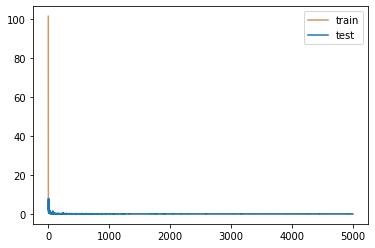

In [17]:
entrenar_modelo = False
if entrenar_modelo:
    model = Sequential()
    model.add(Dense(1000, input_dim=n_input, activation='relu'))
    model.add(Dense(500, input_dim=n_input, activation='relu'))
    model.add(Dense(n_out))
    model.compile(loss='mse', optimizer='adam')

    # Hacemos uso de los checkpoint para ir almacenando el modelo con menor error en el conjunto de entrenamiento
    path_checkpoint = f"results_mlp/tmp_checkpoint_mlp_1000_500_64"
    checkpoint = ModelCheckpoint(path_checkpoint, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

    callbacks_list = [checkpoint]

    history = model.fit(train_x, train_y, epochs=5000, batch_size=64, verbose=2, validation_data=(test_x, test_y), callbacks=callbacks_list)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # Almacenamos la historia de entrenamiento serializada
    with open(os.path.join(path_checkpoint, "history.pickle"), "wb") as handle:
        pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    last_model = model

# Cargamos el mejor modelo
model = load_model(path_best_model_one_output)

if entrenar_modelo is False:
    with open(f"{path_best_model_one_output}/history.pickle", "rb") as handle:
        history = pickle.load(handle)

    plt.plot(history['loss'], label='train')
    plt.plot(history['val_loss'], label='test')
    plt.legend()
    plt.show()

## Generar predicciones de forma recursiva

En caso de que deseemos generar predicciones de forma recursiva, podemos utilizar la celda siguiente. En este caso las predicciones para el modelo de 1 salida se han generado y almacenado serializadas, y las podemos cargar directamente.

Root Mean Squared Error: [2.025]. RMSE in predictions at n step 0.06, 0.10, 0.15, 0.21, 0.27, 0.35, 0.44, 0.53, 0.64, 0.76, 0.89, 1.02, 1.17, 1.32, 1.47, 1.64, 1.80, 1.96, 2.13, 2.28, 2.44, 2.59, 2.74, 2.88, 3.02, 3.14, 3.27, 3.38, 3.49, 3.59


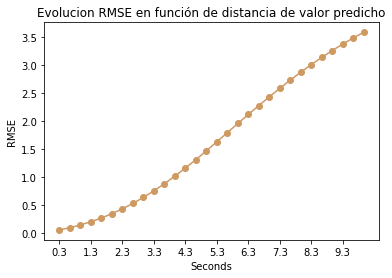

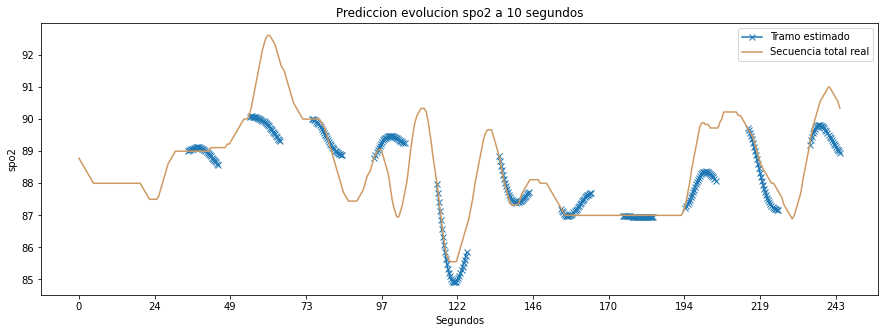

In [18]:
generar_predicciones_recursivas = False

# Cargamos el modelo en el que queremos generar predicciones recursivas
path_modelo = path_best_model_one_output
model = load_model(path_modelo)

# Indicamos cuantos segundos de predicciones queremos obtener
total_seconds_prediction=10 

number_forward_predictions = calcular_numero_forward_predictions(total_seconds_prediction=total_seconds_prediction, time_step=time_step, n_out=n_out)

if generar_predicciones_recursivas:

    # Indicamos el número de muestras sobre el que queremos aplicar predicciones recursivas
    number_samples=test_y.shape[0] - number_forward_predictions*n_out

    forward_predicted_list, forward_real_list = make_distance_predictions(total_seconds_prediction=total_seconds_prediction, number_samples=number_samples, test_x = test_x, n_margin=n_margin, n_input=n_input, n_out=n_out, target_real=target_real, model=model, time_step=time_step)

else:
    with open(os.path.join(path_modelo, "predicted_vs_real.pickle"), "rb") as handle:
        forward_predicted_list, forward_real_list = pickle.load(handle)

score, scores = evaluate_forecasts(actual=forward_real_list, predicted=forward_predicted_list)
summarize_scores(score, scores)

plot_predictions(prediction_indices=[i for i in range(5, 210, 20)], predictions=forward_predicted_list, test_y = test_y, target_real=target_real,n_margin=n_margin, n_input=n_input, n_out=n_out*number_forward_predictions, time_step=time_step, title="spo2")

## Representar predicciones

En caso de que nuestro modelo genere las predicciones necesarias, y queramos representar las mismas gráficamente, lo podemos hacer como se realiza a continuación.

Root Mean Squared Error: [1.976]. RMSE in predictions at n step 0.37, 0.33, 0.32, 0.33, 0.37, 0.43, 0.51, 0.61, 0.73, 0.85, 0.99, 1.13, 1.28, 1.43, 1.58, 1.73, 1.87, 2.02, 2.16, 2.29, 2.42, 2.54, 2.66, 2.77, 2.88, 2.98, 3.08, 3.17, 3.26, 3.34


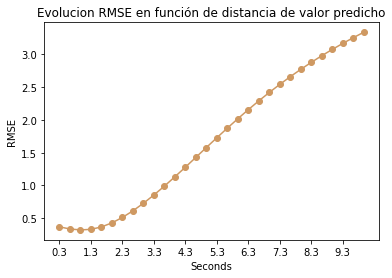

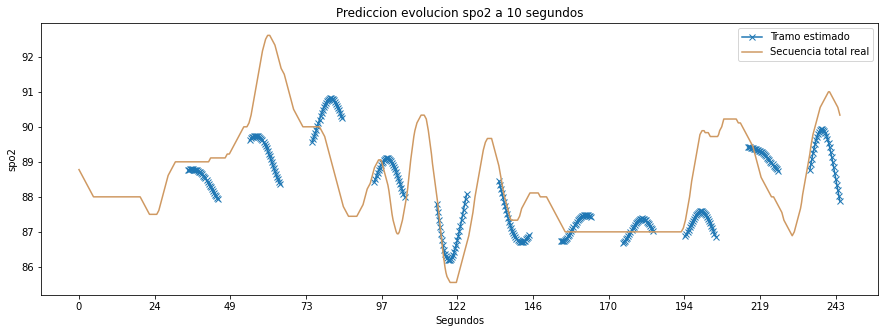

In [19]:
# Cargamos el modelo
path_modelo = path_best_model_multiple_output
model = load_model(path_modelo)

predictions = model.predict(test_x)
number_forward_predictions = calcular_numero_forward_predictions(total_seconds_prediction=total_seconds_prediction, time_step=time_step, n_out=n_out)

score, scores = evaluate_forecasts(actual=predictions, predicted=test_y)
summarize_scores(score, scores)

plot_predictions(prediction_indices=[i for i in range(5, 210, 20)], predictions=predictions, test_y = test_y, target_real=target_real,n_margin=n_margin, n_input=n_input, n_out=n_out*number_forward_predictions, time_step=time_step, title="spo2")

Como podemos ver, ambos modelos tienen un comportamiento similar. Inicialmente con un bajo error cuadrático medio, pero conforme las predicciones son a una mayor distancia, este error aumenta.

## Evaluacion modelo sobre otro paciente

Una vez comprobados los resultados que hemos obtenido para este paciente, es interesante ver si los resultados se pueden extrapolar a otros pacientes. Para ello, se puede cargar otro paciente y comprobarlo

In [20]:
nombre_fichero = "data_3.csv"

paciente_nuevo = Paciente(filename=os.path.join(dataset_dir, nombre_fichero), variables_significativas=variables_significativas)
paciente_nuevo.comprobar_validez_dataset()

paciente_nuevo.suavizar_seniales(smooth_seconds=6)

In [21]:
# Configuramos el tamaño de entrada y salida de las muestras de la red neuronal
time_step = paciente.time_step

seconds_prediction = 10 # Indica que las predicciones son 10 segundos
n_out = round(seconds_prediction/time_step)

# Si queremos predecir únicamente una muestra, n_out = 1

seconds_prior = 30 # Indica que cada muestra contiene los 30 segundos anteriores
n_input = round(seconds_prior/time_step)

seconds_margin = 1 # Espacio entre una muestra y la siguiente
n_margin = round(seconds_margin/time_step)

train_size = 0.1 # Indica el tamaño del conjunto de entrenamiento

In [22]:
# split into train and test
train_nuevo, test_nuevo = train_test_split(data=paciente_nuevo.df_smothed["spo2"].values,train_size=train_size)

# Transformamos a serie supervisada
train_x_nuevo, train_y_nuevo = to_supervised(train_nuevo, n_input, n_out=n_out, n_margin=n_margin)
test_x_nuevo, test_y_nuevo = to_supervised(test_nuevo, n_input, n_out=n_out, n_margin=n_margin)

# Almacenamos la lista con el target real
target_real_nuevo = test_nuevo

In [23]:
train_x_nuevo.shape, train_y_nuevo.shape, test_x_nuevo.shape, test_y_nuevo.shape

((2812, 90), (2812, 30), (25624, 90), (25624, 30))

Root Mean Squared Error: [1.818]. RMSE in predictions at n step 0.39, 0.35, 0.32, 0.32, 0.34, 0.38, 0.45, 0.54, 0.64, 0.75, 0.87, 1.00, 1.13, 1.26, 1.40, 1.54, 1.67, 1.80, 1.94, 2.07, 2.19, 2.32, 2.44, 2.55, 2.67, 2.78, 2.88, 2.98, 3.07, 3.16


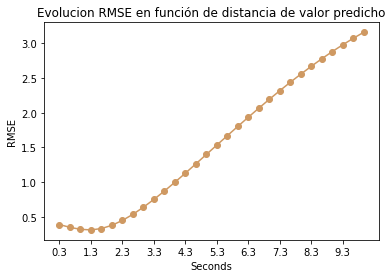

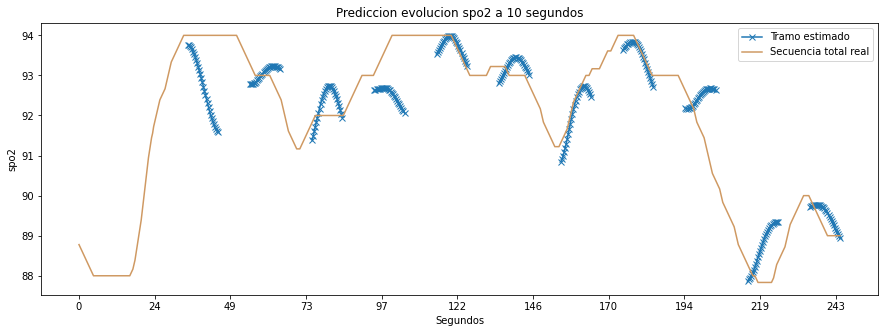

In [24]:
# Cargamos el modelo
path_modelo = path_best_model_multiple_output
model = load_model(path_modelo)

predictions = model.predict(test_x_nuevo)
number_forward_predictions = calcular_numero_forward_predictions(total_seconds_prediction=total_seconds_prediction, time_step=time_step, n_out=n_out)

score, scores = evaluate_forecasts(actual=predictions, predicted=test_y_nuevo)
summarize_scores(score, scores)

plot_predictions(prediction_indices=[i for i in range(5, 210, 20)], predictions=predictions, test_y = test_y_nuevo, target_real=target_real_nuevo,n_margin=n_margin, n_input=n_input, n_out=n_out*number_forward_predictions, time_step=time_step, title="spo2")

Podemos observar visualmente las predicciones sobre otro paciente.

Para analizar más en detalle los resultados, se recomiendo analizar el notebook XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX